# TP 4 - Tópicos de Minería de Datos
### Juan Ignacio Farizano

--------------------------------------------------------------------------------

In [ ]:
# imports iniciales
library(adabag)
library(e1071)
library(randomForest)
library(caret)

load("TP4.Rdata") # esp_train''RRL''esp_test''diag_test''.Random.seed''diag_train'

error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

--------------------------------------------------------------------------------
## Ejercicio 1

#### Espirales con ruido

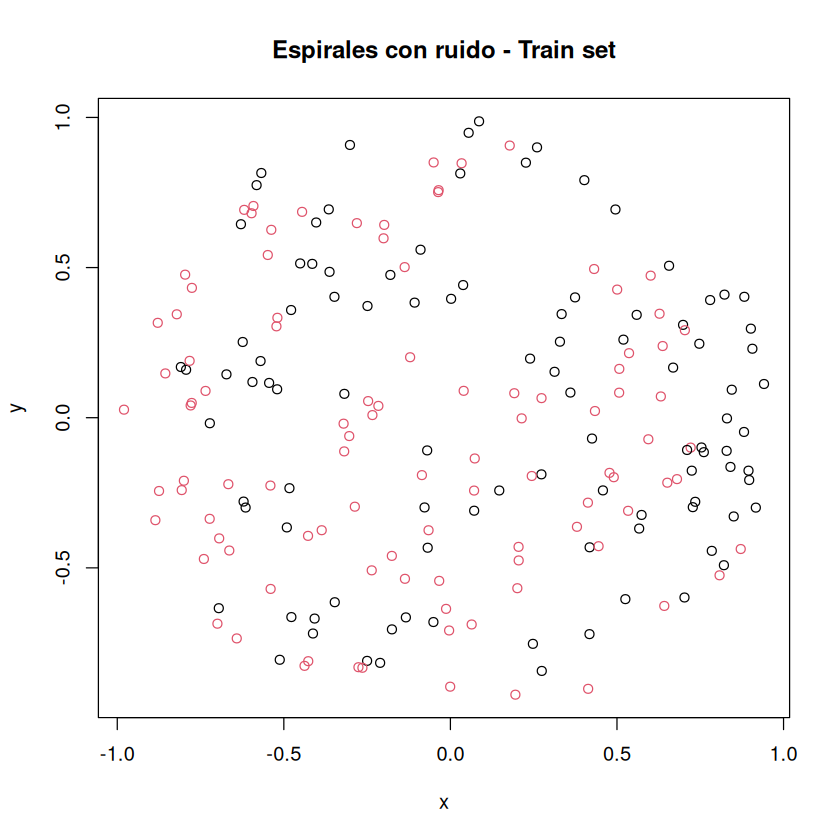

In [17]:
#grafico los datos de entrenamiento
plot(esp_train[,c(1,2)], col=esp_train[,3], main="Espirales con ruido - Train set")

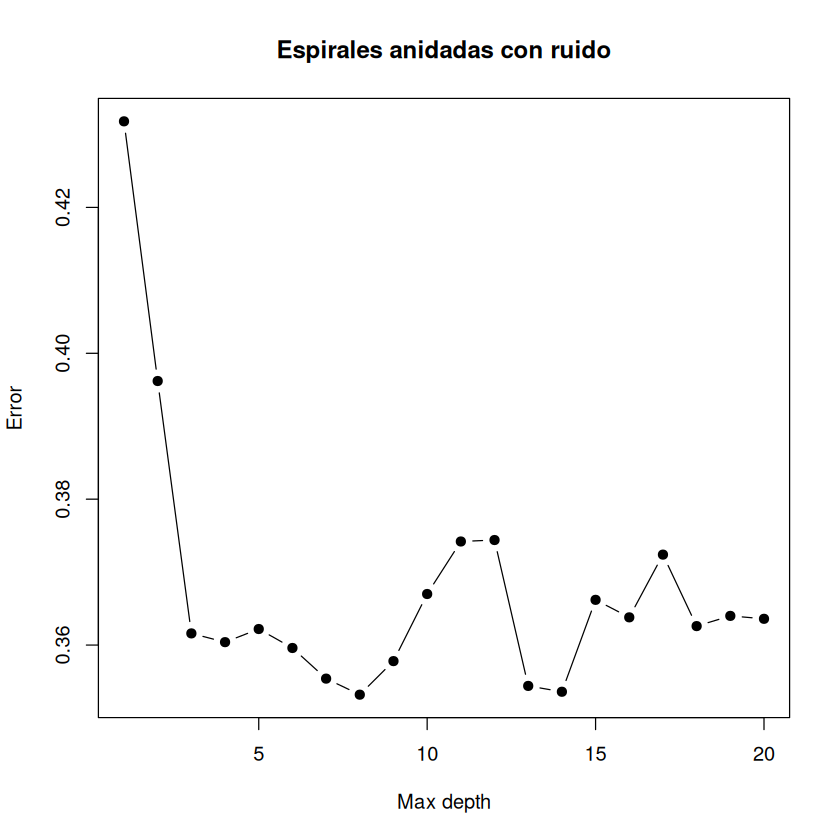

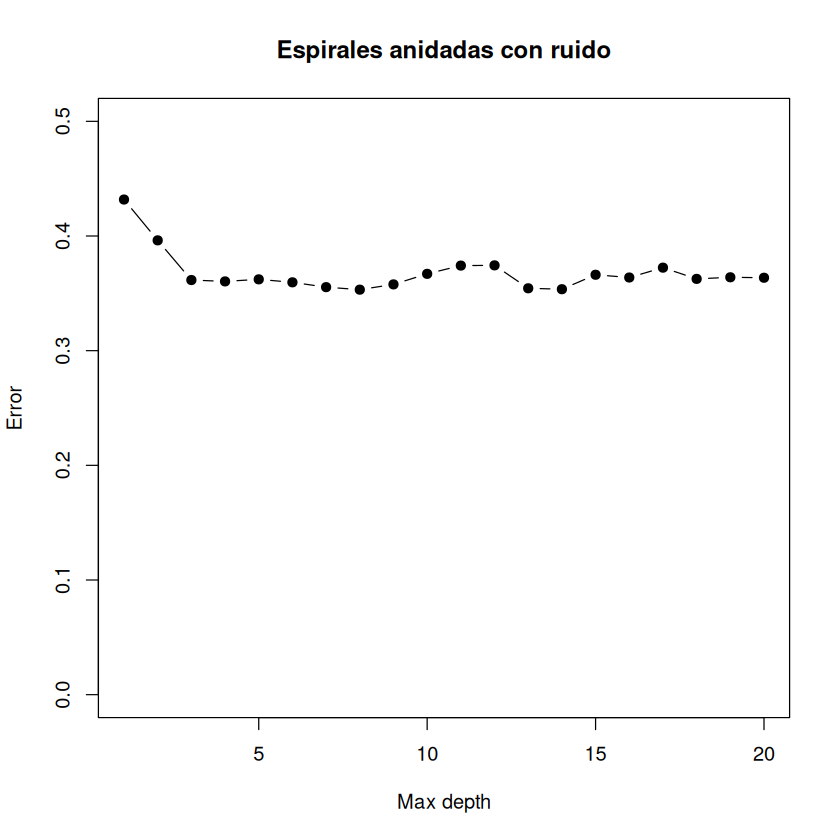

In [2]:
errors <- double(20)

for (depth in 1:20) { 
  esp.adaboost <- boosting(class ~ ., data = esp_train, mfinal = 200, coef = "Freund", control = rpart.control(maxdepth = depth))
  pred <- predict(esp.adaboost, newdata = esp_test, type = "class");
  errors[depth] <- pred$error
}

plot(1:20, errors, type = "b", pch=19, xlab="Max depth", ylab="Error", main="Espirales anidadas con ruido")
plot(1:20, errors, type = "b", pch=19, xlab="Max depth", ylab="Error", main="Espirales anidadas con ruido", ylim=c(0, 0.5))

Los resultados no son buenos, con un error de casi el 40% el modelo no sirve 
para este problema. Creo que la mayor causa de esto es la poca cantidad de datos
que tiene el conjunto de entrenamiento, además de que al plotear estos datos
parece haber mucho ruido.

#### Diagonal

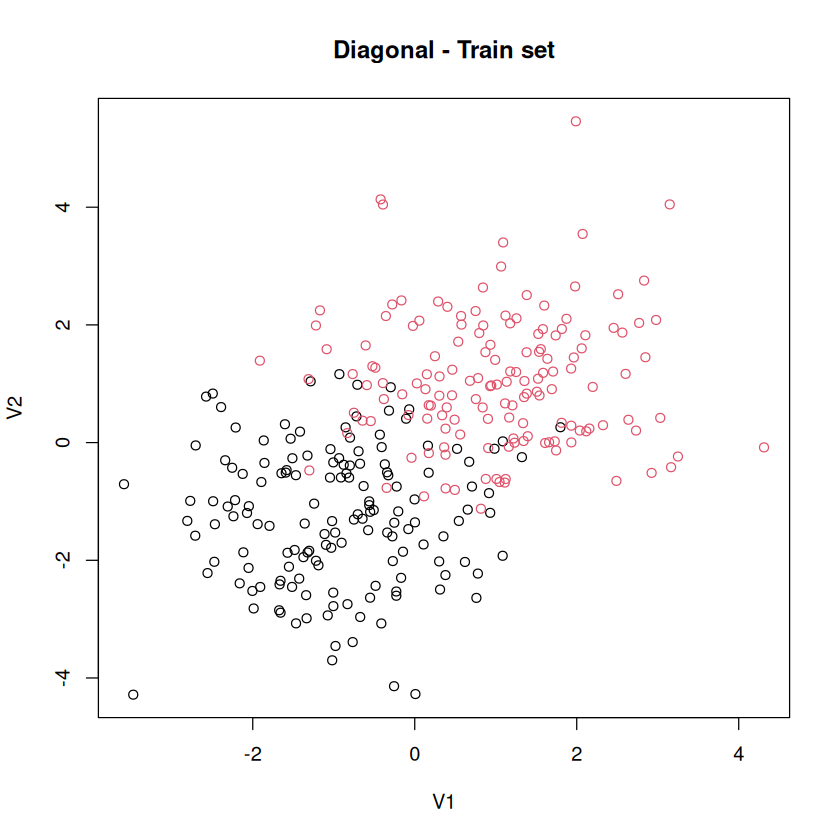

In [18]:
#grafico los datos de entrenamiento
plot(diag_train[,c(1,2)], col=diag_train[,3], main="Diagonal - Train set")

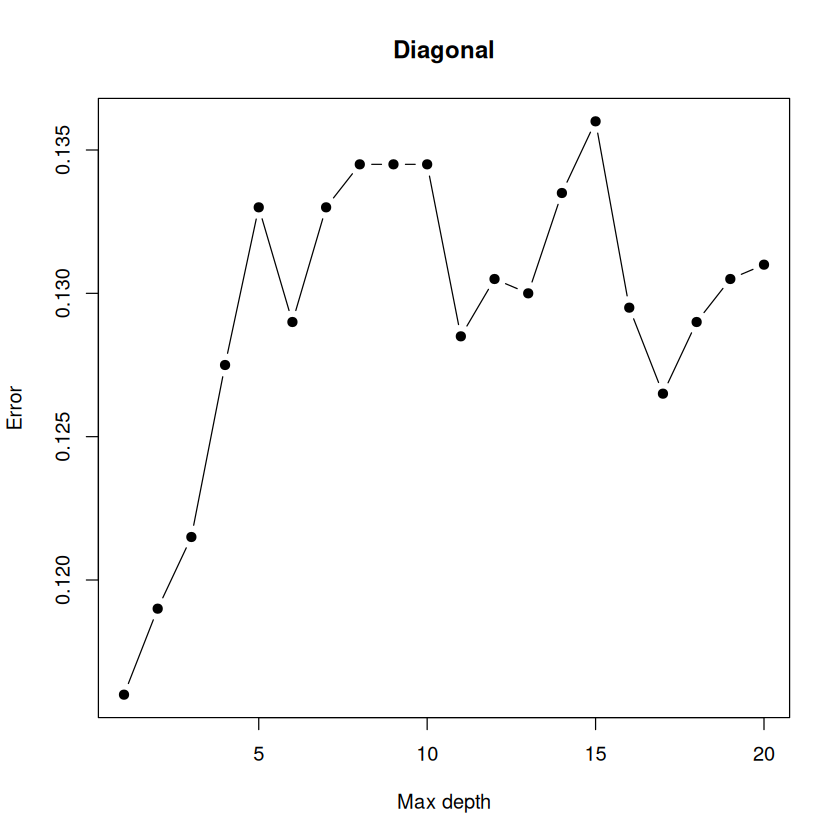

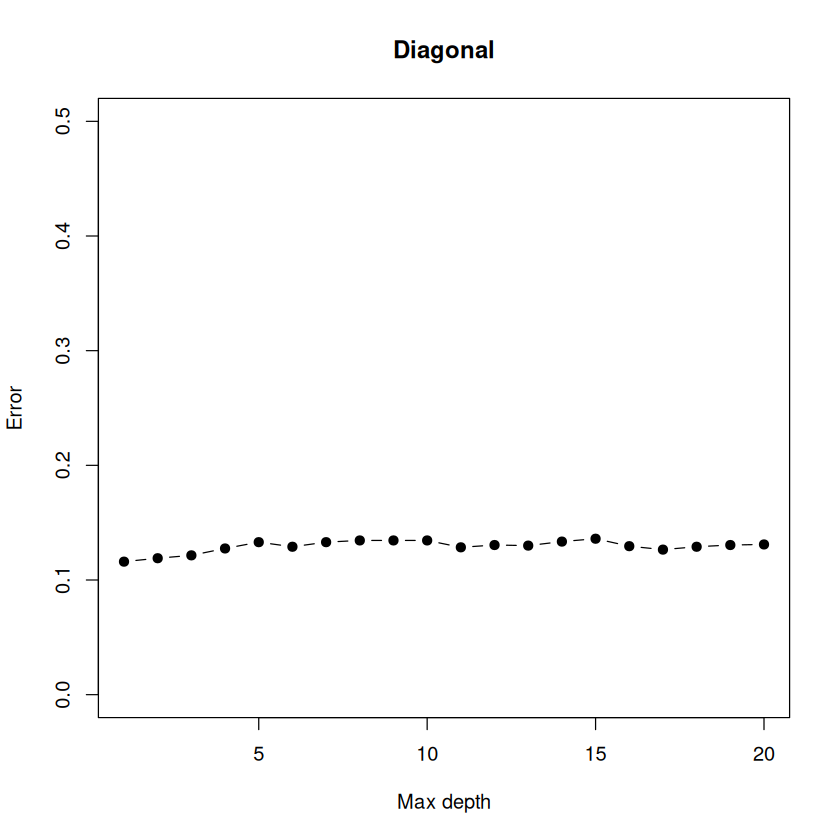

In [106]:
errors <- double(20)

for (depth in 1:20) { 
  diag.adaboost <- boosting(class ~ ., data = diag_train, mfinal = 200, coef = "Freund", control = rpart.control(maxdepth = depth))
  pred <- predict(diag.adaboost, newdata = diag_test, type = "class");
  errors[depth] <- pred$error
}

plot(1:20, errors, type = "b", pch=19, xlab="Max depth", ylab="Error", main="Diagonal")
plot(1:20, errors, type = "b", pch=19, xlab="Max depth", ylab="Error", main="Diagonal", ylim=c(0,0.5))

En el primer gráfico parece que el error salta bastante al aumentar la profundidad
de los árboles en cada iteración, pero sacando el zoom se ve que esta diferencia
no es significativa, pienso que este pequeño salto se debe a que diagonal
no es un problema muy complejo y al aumentar la profundidad de los árboles empieza
a haber sobreajuste, aunque no sea tan notable.

Pero finalmente, el error de este modelo es muy bueno, teniendo en cuenta que existe
un pequeño overlap de las clases obtenido al generar los datos y siempre va a haber
un mínimo error al clasificar.

--------------------------------------------------------------------------------
## Ejercicio 2

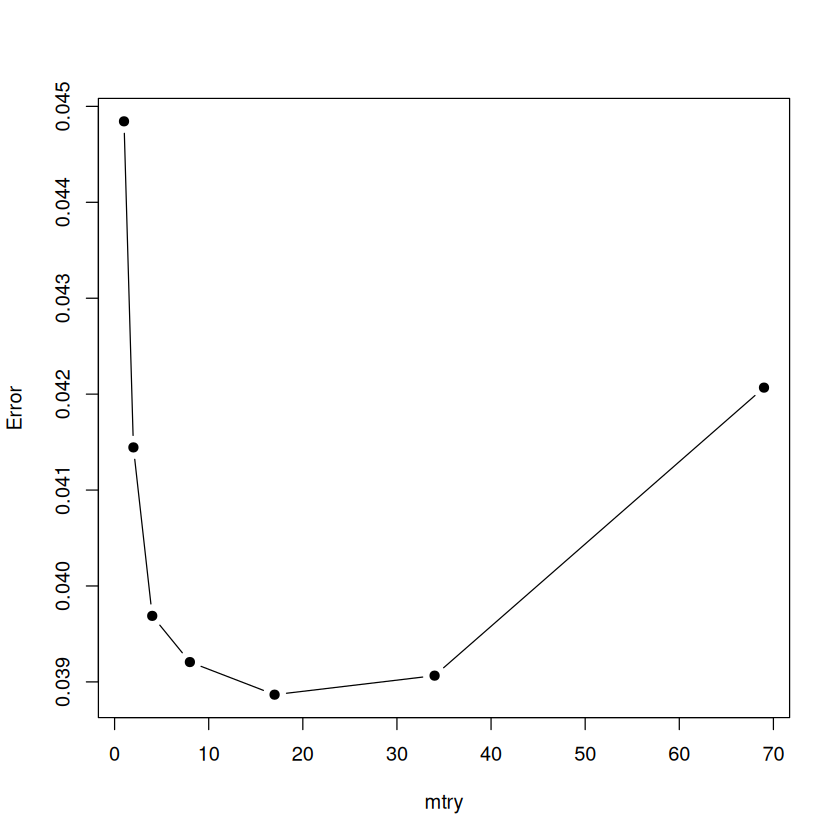

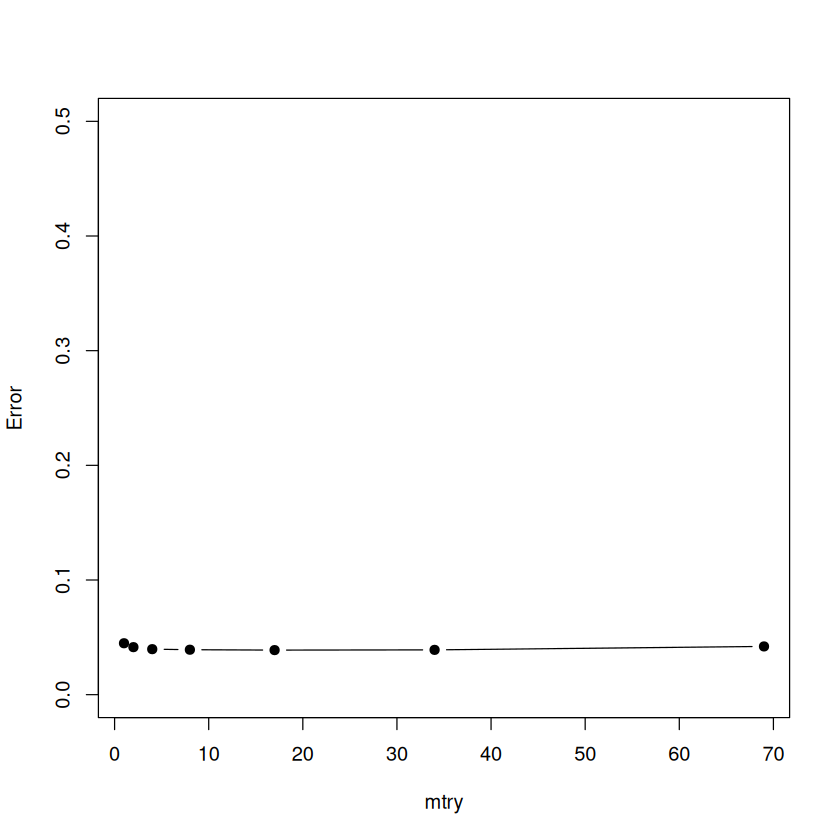

In [107]:
features_count <- ncol(RRL) - 1
m_values <- 0:floor(log(features_count, 2))
m_values <- floor(features_count / (2 ^ m_values))
m_errors <- double(length(m_values))

for (i in 1:length(m_errors)) {
  m <- m_values[i]

  for (j in 1:5) {
    rrl.rf <- randomForest(Tipo ~ ., data=RRL, ntree=1000, mtry=m)
    m_errors[i] <- m_errors[i] + rrl.rf$err.rate[1000]
  }
}

m_errors <- m_errors / 5
plot(m_values, m_errors, type = "b", pch=19, xlab="mtry", ylab="Error")
plot(m_values, m_errors, type = "b", pch=19, xlab="mtry", ylab="Error", ylim=c(0, 0.5))


De vuelta, por una situación parecida a la sucedida en el ejercicio anterior
grafico los errores dos veces, en el primero se ven saltos grandes en el error
pero en el segundo al verlo en otra escala la diferencia es mínima.

Volviendo al primer gráfico, por la forma de este me da a pensar que hay
variables ruidosas y al agarrar menos mejoran los resultados pero hay una cantidad
grande de variables importantes ya que el mínimo error es agarrando de a 17.

El error sigue siendo muy bueno.

--------------------------------------------------------------------------------
## Ejercicio 3

In [115]:
load("lampone.Rdata")
lampone <- lampone[,-c(1, 144)] # Saco la columna 144 porque es un factor y me rompe todo. Y la 1 porque no la usamos
# elimino las columnas cuyos datos son todos iguales a 0, porque me rompe todo
# y además no tienen datos
ceros <- colSums(lampone[,-142])
lampone[,names(ceros[ceros == 0])] <- list(NULL)

El dataset tiene solo 49 instancias, por lo que voy a utilizar k-cross validation para clasificar los datos, excepto para random forest porque ya es posible estimar el error
de forma conservadora con el out-of-bag error.

In [137]:
# Creo los folds
indexData <- createFolds(t(lampone[, "N_tipo"]), k = 5)

#### Random Forest


 -- mtry con menor error -> 31 y error: 0.07346939  --


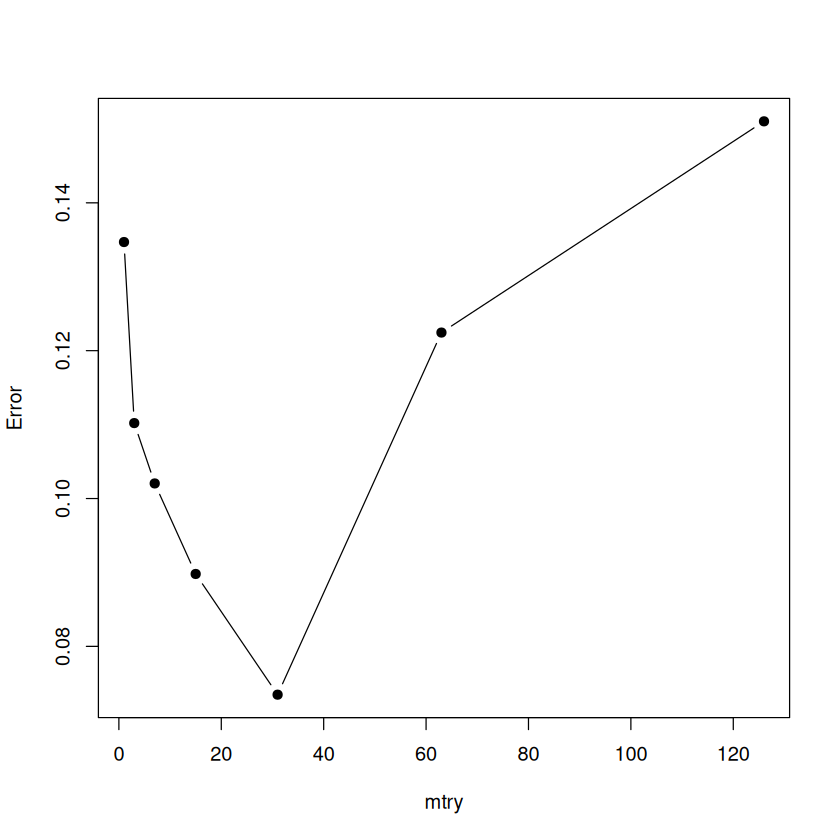

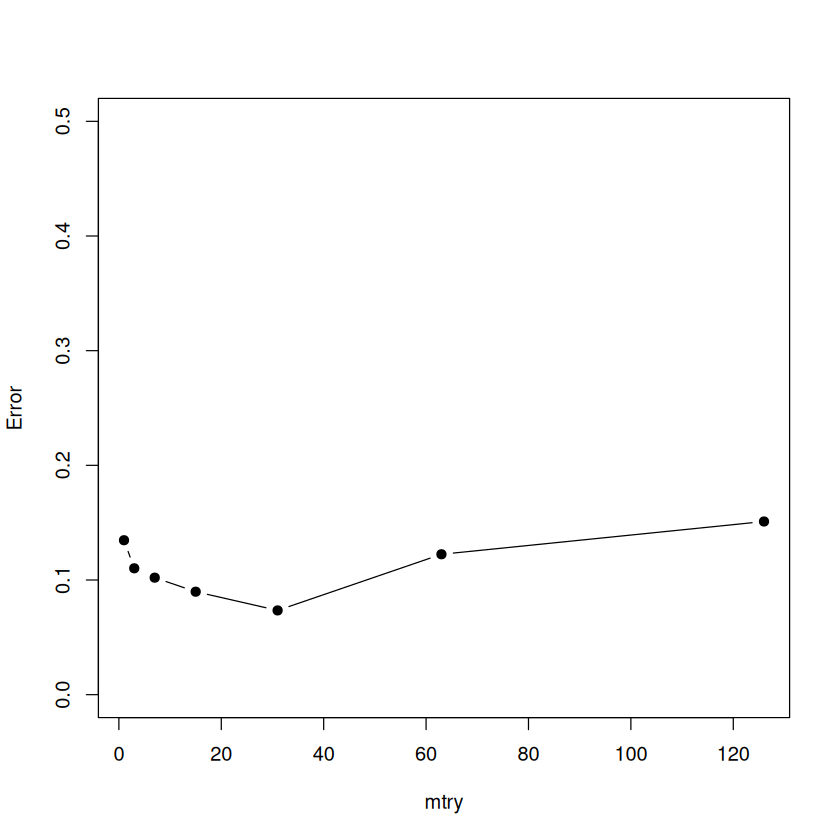

In [138]:
features_count <- ncol(lampone) - 1
m_values <- 0:floor(log(features_count, 2))
m_values <- floor(features_count / (2 ^ m_values))
m_errors <- double(length(m_values))

for (i in 1:length(m_errors)) {
  m <- m_values[i]

  for (j in 1:5) {
    rrl.rf <- randomForest(N_tipo ~ ., data=lampone, ntree=1000, mtry=m)
    m_errors[i] <- m_errors[i] + rrl.rf$err.rate[1000]
  }
}

m_errors <- m_errors / 5
cat("\n -- mtry con menor error ->", m_values[which.min(m_errors)], "y error:", m_errors[which.min(m_errors)] ," --\n")
plot(m_values, m_errors, type = "b", pch=19, xlab="mtry", ylab="Error")
plot(m_values, m_errors, type = "b", pch=19, xlab="mtry", ylab="Error", ylim=c(0, 0.5))

#### Adaboost

In [139]:
error <- 0

# Robado de IIA
for (kFold in 1:5) {
  foldTrain <- lampone[setdiff(seq(1:dim(lampone)[1]), indexData[[kFold]]), ]
  foldTest <- lampone[indexData[[kFold]], ]

  # tuve que sacar el argumento de control para maxdepth porque se rompía.
  # Al haber tantas variables para tan pocos datos hay problemas con la creación
  # de árboles que hace rpart, o algo así leí
  lamp.adaboost <- boosting(N_tipo ~ ., data = foldTrain, mfinal = 200, coef = "Freund")
  pred <- predict(lamp.adaboost, newdata = foldTest, type = "class");
  error <- error + pred$error
}

error <- error / 5

cat("\n -- Error ->", error, " --\n")


 -- Error -> 0.1044444  --


#### SVM

In [140]:
error.poly <- 0
error.rbf <- 0

# Robado de IIA
for (kFold in 1:5) {
  foldTrain <- lampone[setdiff(seq(1:dim(lampone)[1]), indexData[[kFold]]), ]
  foldTest <- lampone[indexData[[kFold]], ]

  suppressWarnings(poly.svm <- svm(N_tipo ~ ., data = foldTrain, kernel="polynomial"))
  poly.pred <- predict(poly.svm, newdata = foldTest, type = "class");
  error.poly <- error.poly + error.rate(poly.pred, foldTest$N_tipo)

  suppressWarnings(rbf.svm <- svm(N_tipo ~ ., data = foldTrain, kernel="radial"))
  rbf.pred <- predict(rbf.svm, newdata = foldTest, type = "class");
  error.rbf <- error.rbf + error.rate(rbf.pred, foldTest$N_tipo)
}

error.poly <- error.poly / 5
error.rbf <- error.rbf / 5

cat("\n -- Error polynomial ->", error.poly, " --\n")
cat("\n -- Error rbf ->", error.rbf, " --\n")


 -- Error polynomial -> 0.1844444  --

 -- Error rbf -> 0.3688889  --


No encuentro nada interesante para comentar, solo que Random Forest obtuvo el menor
error, seguido por Adaboost y por último SVM, donde a este último quizás podría
haber obtenido mejores resultados jugando más con los parámetros, pero no estaba
seguro de como hacerlo o qué valores probar.

--------------------------------------------------------------------------------
## Ejercicio 4

In [149]:
# Creo los folds
indexData <- createFolds(t(RRL[, "Tipo"]), k = 5)

#### Random Forest (nuevamente para que quede todo junto)


 -- mtry con menor error -> 17 y error: 0.0388102  --


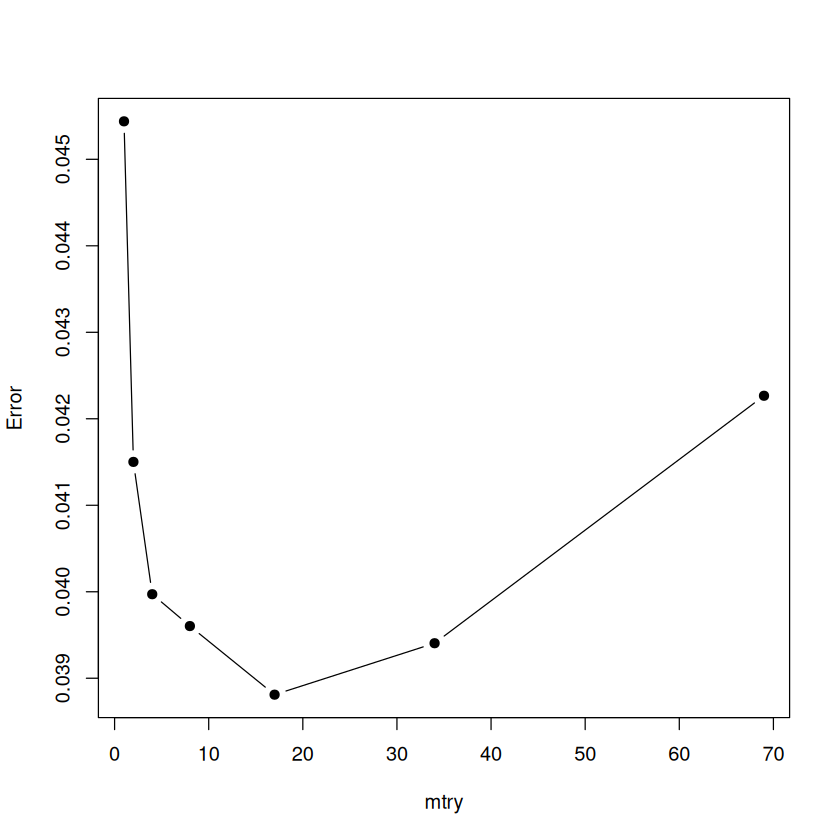

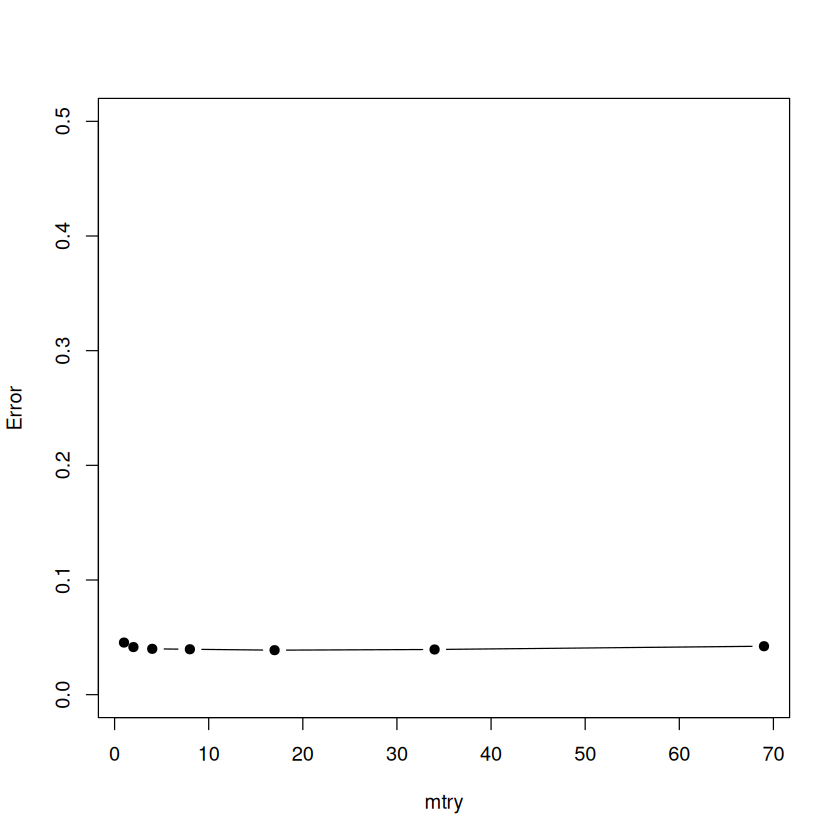

In [150]:
features_count <- ncol(RRL) - 1
m_values <- 0:floor(log(features_count, 2))
m_values <- floor(features_count / (2 ^ m_values))
m_errors <- double(length(m_values))

for (i in 1:length(m_errors)) {
  m <- m_values[i]

  for (j in 1:5) {
    rrl.rf <- randomForest(Tipo ~ ., data=RRL, ntree=1000, mtry=m)
    m_errors[i] <- m_errors[i] + rrl.rf$err.rate[1000]
  }
}

m_errors <- m_errors / 5
cat("\n -- mtry con menor error ->", m_values[which.min(m_errors)], "y error:", m_errors[which.min(m_errors)] ," --\n")
plot(m_values, m_errors, type = "b", pch=19, xlab="mtry", ylab="Error")
plot(m_values, m_errors, type = "b", pch=19, xlab="mtry", ylab="Error", ylim=c(0, 0.5))

#### Adaboost

In [151]:
error <- 0

# Robado de IIA
for (kFold in 1:5) {
  foldTrain <- RRL[setdiff(seq(1:dim(RRL)[1]), indexData[[kFold]]), ]
  foldTest <- RRL[indexData[[kFold]], ]

  # tuve que sacar el argumento de control para maxdepth porque se rompía.
  # Al haber tantas variables para tan pocos datos hay problemas con la creación
  # de árboles que hace rpart, o algo así leí
  lamp.adaboost <- boosting(Tipo ~ ., data = foldTrain, mfinal = 200, coef = "Freund")
  pred <- predict(lamp.adaboost, newdata = foldTest, type = "class");
  error <- error + pred$error
}

error <- error / 5

cat("\n -- Error ->", error, " --\n")


 -- Error -> 0.03569405  --


#### SVM

In [153]:
error.poly <- 0
error.rbf <- 0

# Robado de IIA
for (kFold in 1:5) {
  foldTrain <- RRL[setdiff(seq(1:dim(RRL)[1]), indexData[[kFold]]), ]
  foldTest <- RRL[indexData[[kFold]], ]

  suppressWarnings(poly.svm <- svm(Tipo ~ ., data = foldTrain, kernel="polynomial"))
  poly.pred <- predict(poly.svm, newdata = foldTest, type = "class");
  error.poly <- error.poly + error.rate(poly.pred, foldTest$Tipo)

  suppressWarnings(rbf.svm <- svm(Tipo ~ ., data = foldTrain, kernel="radial"))
  rbf.pred <- predict(rbf.svm, newdata = foldTest, type = "class");
  error.rbf <- error.rbf + error.rate(rbf.pred, foldTest$Tipo)
}

error.poly <- error.poly / 5
error.rbf <- error.rbf / 5

cat("\n -- Error polynomial ->", error.poly, " --\n")
cat("\n -- Error rbf ->", error.rbf, " --\n")


 -- Error polynomial -> 0.1155807  --

 -- Error rbf -> 0.08569405  --


Igual al ejercicio 3, los resultados son mejores pero el comentario a realizar
es el mismo, excepto para SVM donde el modelo esta vez fue mucho mejor, especialmente
para el kernel RBF. Los resultados son muy buenos, llegando a un 3% aproximadamente
de error.